In [1]:
%matplotlib notebook

In [2]:
import matplotlib as mpl
# mpl.use('agg')
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import numpy as np
import sys,time
from mdp import value_iter,policy_eval

In [3]:
MAPS = \
'''
xxxxxxxxxxxxx
xoooooxooooox
xoooooxooooox
xooooooooooox
xoooooxooooox
xoooooxooooox
xxoxxxxooooox
xoooooxxxoxxx
xoooooxooooox
xoooooxooooox
xooooooooooox
xoooooxooooox
xxxxxxxxxxxxx
'''
LEFT = 0
RIGHT = 1
UP = 2
DOWN = 3
GAMMA = 0.9
THETA = 0.0001

In [4]:
def gen_trans_mat(maps,p,r,term_set,unmask_set=None):
    moveup = lambda x,y:(x-1,y)
    movedown = lambda x,y:(x+1,y)
    moveleft = lambda x,y:(x,y-1)
    moveright = lambda x,y:(x,y+1)
    
    def reward(x,y):
        return (r,True) if (x,y) in term_set else (0,False)
    
    maps = maps.split('\n')[1:-1]
    P = {}
    for x,row in enumerate(maps):
        for y,letter in enumerate(row):
            if unmask_set == None or (x,y) in unmask_set:
                if letter != 'x' and (x,y) not in term_set:
                    P[(x,y)] = {}
                    for a in range(4):
                        item = []
                        for a_ in range(4):
                            if a == UP:
                                x_,y_ = moveup(x,y)
                            elif a == DOWN:
                                x_,y_ = movedown(x,y)
                            elif a == LEFT:
                                x_,y_ = moveleft(x,y)
                            elif a == RIGHT:
                                x_,y_ = moveright(x,y)
                            x_,y_ = (x_,y_) if maps[x_][y_] != 'x' else (x,y)
                            rew,done = reward(x_,y_)
                            prob = p if a_ == a else (1-p)/3
                            item += [(prob,(x_,y_),rew,done)]
                        P[(x,y)][a] = item.copy()
    return P

In [5]:
def hall_cells(xrange,yrange):
    output = set()
    for x in xrange:
        for y in yrange:
            output.add((x,y))
    return output

In [6]:
def init_v(states,goal_pos,goal_value):
    v = {}
    for s in states:
        v[s] = 0
    v[goal_pos] = goal_value
    return v

In [7]:
def twoway_prob(twoway,action,terminal,V,gamma):
    trans_mat = gen_trans_mat(maps=MAPS,r=0,p=2/3,term_set=set(),unmask_set=set([twoway]))
    prob = 0
    for item in trans_mat[twoway][action]:
        if item[1] == terminal:
            prob += gamma * item[0]
        elif item[1] in V.keys():
            prob += gamma * item[0] * V[item[1]]
    return prob

In [8]:
def opt_into_trans_mat(opt_list,trans_mat):
    for opt in opt_list:
        trans_mat_ = gen_trans_mat(maps=MAPS,r=0,p=2/3,term_set=opt['term_set'],unmask_set=opt['init_set'])
        # By setting the initial value function to be 1 at target cell and running value iteration
        # algorithm, we get the discounted transition probability to the target cell from any cell.
        V_init = init_v(opt['init_set'].union(opt['term_set']),opt['goal_pos'],1)
        _,policy = value_iter(trans_mat_,V_init,THETA,GAMMA)
        for s_ in opt['term_set']:
            V_init = init_v(opt['init_set'].union(opt['term_set']),s_,1)
            V = policy_eval(trans_mat_,V_init,policy,THETA,GAMMA)
            # Hard code the action at twoway cells. Not elegant but works.
            t,a = opt['twoway']
            V[t] = twoway_prob(t,a,s_,V,GAMMA)
            for s in trans_mat.keys():
                if s in V.keys():
                    # Add the outcome of option into the orginal transition matrix.
                    # The expected return by executing the option is 0 in this example. But in general,
                    # it can be evaluated by policy evaluation with correct transition matrix.
                    trans_mat[s][opt['label']] = trans_mat[s].setdefault(opt['label'],[]) \
                        + [(V[s]/GAMMA,s_,0,False)]
    return trans_mat

In [9]:
def plot_gridworld(maps,V):
    maps = maps.split('\n')[1:-1]
    height = len(maps)
    width = len(maps[0])
    image = np.empty((height,width))
    for x,row in enumerate(maps):
        for y,letter in enumerate(row):
            if letter == 'x':
                image[x,y] = -1
            else:
                image[x,y] = 1
    fig = plt.figure()
    ax = fig.gca()
    cmap = mpl.colors.ListedColormap(['red','white'])
    bounds = [-1,0,1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    ax.set_xticks(range(width))
    ax.set_yticks(range(height))
    plt.imshow(image,cmap=cmap,extent=[0,width,0,height],norm=norm)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    for s,val in V.items():
        x,y = s
        x = height - x - 0.5
        y = y + 0.5
        circle = plt.Circle((y,x),val/2.1,color='k')
        ax.add_artist(circle)
    ax.grid(which='major',color='black',alpha=1)
    plt.show()

In [10]:
opt1 = {'label':4, 
        'init_set':hall_cells(range(1,6),range(1,6)), 
        'term_set':set([(6,2),(3,6),(7,2)]), 
        'twoway':((6,2),UP), 'goal_pos':(3,6) 
       } 
opt2 = {'label':5, 
        'init_set':hall_cells(range(1,6),range(1,6)), 
        'term_set':set([(6,2),(3,6),(3,7)]), 
        'twoway':((3,6),LEFT), 'goal_pos':(6,2) 
       } 
opt3 = {'label':6, 
        'init_set':hall_cells(range(7,12),range(1,6)), 
        'term_set':set([(6,2),(10,6),(5,2)]), 
        'twoway':((10,6),LEFT), 'goal_pos':(6,2)
       } 
opt4 = {'label':7, 
        'init_set':hall_cells(range(7,12),range(1,6)), 
        'term_set':set([(6,2),(10,6),(10,7)]), 
        'twoway':((6,2),DOWN), 'goal_pos':(10,6)
       } 
opt5 = {'label':8, 
        'init_set':hall_cells(range(1,7),range(7,12)), 
        'term_set':set([(3,6),(7,9),(8,9)]), 
        'twoway':((7,9),UP), 'goal_pos':(3,6)
       } 
opt6 = {'label':9, 
        'init_set':hall_cells(range(1,7),range(7,12)), 
        'term_set':set([(3,6),(7,9),(3,5)]), 
        'twoway':((3,6),RIGHT), 'goal_pos':(7,9)
       } 
opt7 = {'label':10, 
        'init_set':hall_cells(range(8,12),range(7,12)), 
        'term_set':set([(10,6),(7,9),(10,5)]), 
        'twoway':((7,9),DOWN), 'goal_pos':(10,6)
       } 
opt8 = {'label':11, 
        'init_set':hall_cells(range(8,12),range(7,12)), 
        'term_set':set([(10,6),(7,9),(6,9)]), 
        'twoway':((10,6),RIGHT), 'goal_pos':(7,9)
       } 
opt_list = [opt1,opt2,opt3,opt4,opt5,opt6,opt7,opt8]

{0: [(0.6666666666666666, (3, 5), 0, False), (0.11111111111111112, (3, 5), 0, False), (0.11111111111111112, (3, 5), 0, False), (0.11111111111111112, (3, 5), 0, False)], 1: [(0.11111111111111112, (3, 7), 0, False), (0.6666666666666666, (3, 7), 0, False), (0.11111111111111112, (3, 7), 0, False), (0.11111111111111112, (3, 7), 0, False)], 2: [(0.11111111111111112, (3, 6), 0, False), (0.11111111111111112, (3, 6), 0, False), (0.6666666666666666, (3, 6), 0, False), (0.11111111111111112, (3, 6), 0, False)], 3: [(0.11111111111111112, (3, 6), 0, False), (0.11111111111111112, (3, 6), 0, False), (0.11111111111111112, (3, 6), 0, False), (0.6666666666666666, (3, 6), 0, False)], 4: [(0.0, (6, 2), 0, False), (1.1111111111111112, (3, 6), 0, False), (0.0, (7, 2), 0, False)], 5: [(0.0, (3, 7), 0, False), (0.5314410000000003, (6, 2), 0, False), (0.0, (3, 6), 0, False)], 8: [(0.0, (8, 9), 0, False), (1.1111111111111112, (3, 6), 0, False), (0.0, (7, 9), 0, False)], 9: [(0.0, (3, 5), 0, False), (0.0, (3, 6),

<IPython.core.display.Javascript object>


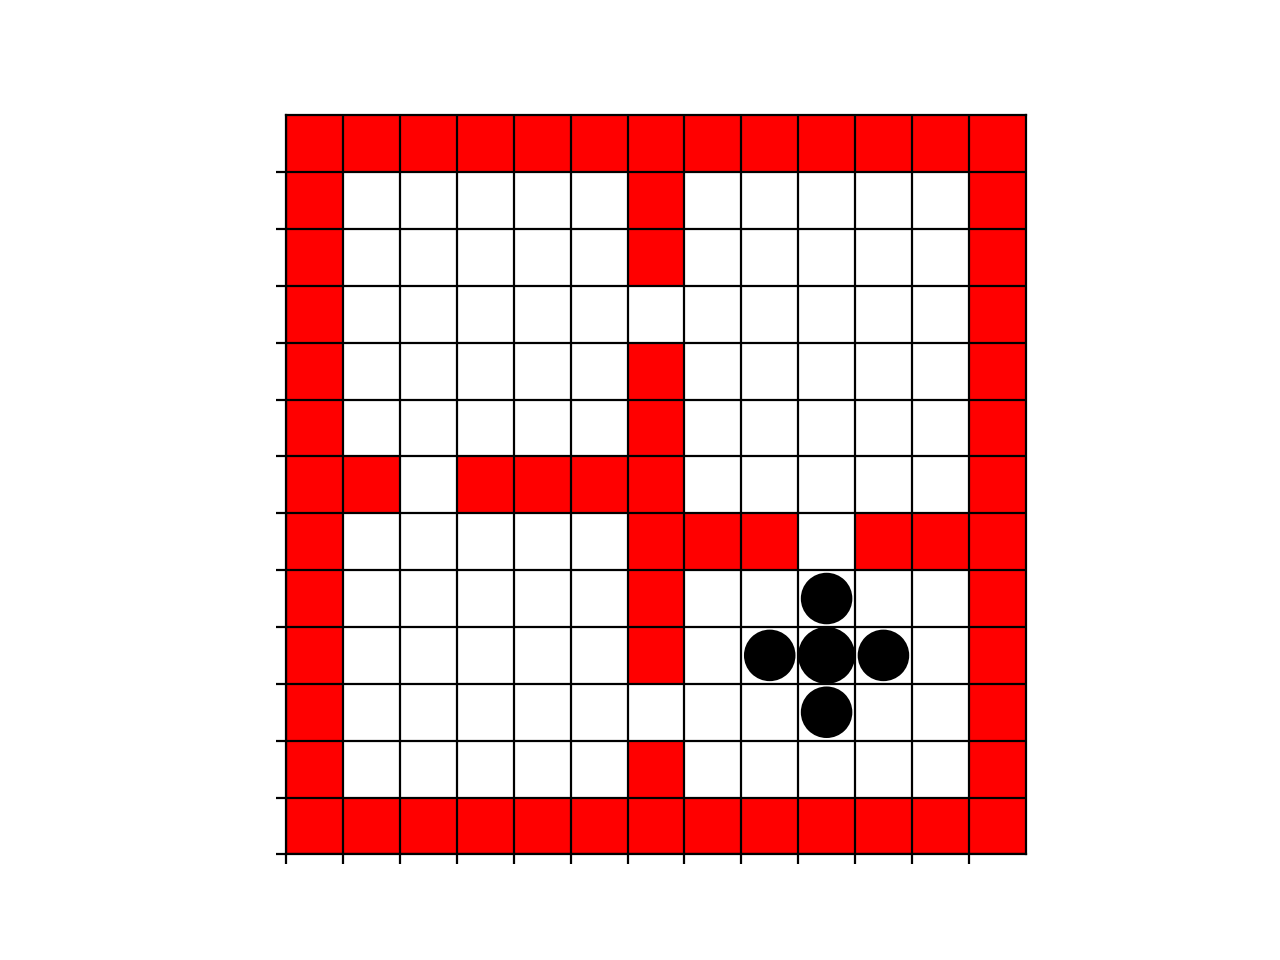

In [15]:
trans_mat = gen_trans_mat(maps=MAPS,r=0,p=2/3,term_set=set([(9,9)]))
states = set()
for key,_ in trans_mat.items():
    states.add(key)
V_init = init_v(states,(9,9),1)
trans_mat = opt_into_trans_mat(opt_list=opt_list,trans_mat=trans_mat)
print(trans_mat[(3,6)])
V,_ = value_iter(trans_mat,V_init,1,GAMMA,inplace=False)
# V,_ = value_iter(trans_mat,V,1,GAMMA,inplace=False)
# V,_ = value_iter(trans_mat,V,1,GAMMA,inplace=False)
plot_gridworld(MAPS,V)

In [12]:
a = {2:0,3:1,4:1}
a==max(a.values())

False